In [1]:
%matplotlib widget

import os
import sys

sys.path.insert(0, os.getenv("HOME") + "/pycode/MscThesis/")
import pandas as pd
from amftrack.util.sys import get_dates_datetime, get_dirname, temp_path

import ast
from amftrack.plotutil import plot_t_tp1
from scipy import sparse
from datetime import datetime
from amftrack.pipeline.functions.node_id import orient
import pickle
import scipy.io as sio
from pymatreader import read_mat
from matplotlib import colors
import cv2 as cv
import imageio
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import frangi
from skimage import filters
from random import choice
import scipy.sparse
import os
from amftrack.pipeline.functions.extract_graph import (
    from_sparse_to_graph,
    generate_nx_graph,
    sparse_to_doc,
    generate_skeleton,
)
from skimage.feature import hessian_matrix_det
from amftrack.pipeline.functions.experiment_class_surf import Experiment
from amftrack.pipeline.paths.directory import (
    run_parallel,
    find_state,
    directory_scratch,
    directory_project,
    run_parallel_stitch,
)
from bresenham import bresenham
from amftrack.pipeline.functions.node_id import remove_spurs

In [2]:
def streline(linelen, degrees):
    theta = degrees % 180 * np.pi / 180
    ray = (linelen - 1) / 2
    x = int(np.round((linelen - 1) / 2 * np.cos(theta)))
    y = -int(np.round((linelen - 1) / 2 * np.sin(theta)))
    points = np.array(list(bresenham(0, 0, x, y)))
    c, r = np.concatenate((-np.flip(points[:, 0]), [0], points[:, 0])), np.concatenate(
        (-np.flip(points[:, 1]), [0], points[:, 1])
    )
    M = 2 * np.max(np.abs(r)) + 1
    N = 2 * np.max(np.abs(c)) + 1
    line = np.zeros((M, N))
    x0 = np.expand_dims((r + np.max(np.abs(r))), 1)
    y0 = np.expand_dims((c + np.max(np.abs(c))), 1)
    line[x0, y0] = 1
    return line


def stredisk(radius):
    return cv.getStructuringElement(cv.MORPH_ELLIPSE, (2 * radius - 1, 2 * radius - 1))


def bowler_hat(im, no, si):
    o = np.linspace(0, 180, no)
    imol = np.zeros((im.shape[0], im.shape[1], len(si), no))
    imod = np.zeros((im.shape[0], im.shape[1], len(si)))
    for i in range(0, len(si)):
        for j in range(0, no):
            se = streline(si[i], o[j]).astype(np.uint8)
            imol[:, :, i, j] = cv.morphologyEx(im, cv.MORPH_OPEN, se)
        se = stredisk(int(np.round(si[i] / 2))).astype(np.uint8)
        imod[:, :, i] = cv.morphologyEx(im, cv.MORPH_OPEN, se)
    imd = np.zeros((im.shape[0], im.shape[1], len(si)))
    imr = np.zeros((im.shape[0], im.shape[1], len(si)))
    imm = np.zeros((im.shape[0], im.shape[1], len(si)))
    triv = imod == 0
    for i in range(len(si)):
        imm[:, :, i] = np.max(np.squeeze(imol[:, :, i, :]), axis=2)
        imd[:, :, i] = imm[:, :, i] - imod[:, :, i]
    imr[triv] = 0
    imda = np.max(imd, axis=2)
    imda = np.double(imda)
    imda = (imda - np.min(imda[:])) / (np.max(imda[:]) - np.min(imda[:]))
    return imda

In [3]:
im = imageio.imread("20210915_Plate756_025.bmp")
no = 15
si = [30]
low = 150
high = 200
im_blurred = cv.blur(im, (200, 200))
im_back_rem = (im) / ((im_blurred == 0) * np.ones(im_blurred.shape) + im_blurred) * 120
bowled_hat = bowler_hat(-im_back_rem, no, si)
transformed = 255 - 255 * bowled_hat
lowt = (transformed > low).astype(int)
hight = (transformed > high).astype(int)
hyst = filters.apply_hysteresis_threshold(transformed, low, high)
kernel = np.ones((3, 3), np.uint8)
dilation = cv.dilate(hyst.astype(np.uint8) * 255, kernel, iterations=1)
for i in range(3):
    dilation = cv.erode(dilation.astype(np.uint8) * 255, kernel, iterations=1)
    dilation = cv.dilate(dilation.astype(np.uint8) * 255, kernel, iterations=1)
dilated = dilation > 0

nb_components, output, stats, centroids = cv.connectedComponentsWithStats(
    dilated.astype(np.uint8), connectivity=8
)
# connectedComponentswithStats yields every seperated component with information on each of them, such as size
# the following part is just taking out the background which is also considered a component, but most of the time we don't want that.
sizes = stats[1:, -1]
nb_components = nb_components - 1

# minimum size of particles we want to keep (number of pixels)
# here, it's a fixed value, but you can set it as you want, eg the mean of the sizes or whatever
min_size = 4000

# your answer image
img2 = np.zeros((dilated.shape))
# for every component in the image, you keep it only if it's above min_size
for i in range(0, nb_components):
    if sizes[i] >= min_size:
        img2[output == i + 1] = 1
skeletonized = cv.ximgproc.thinning(np.array(255 * img2, dtype=np.uint8))
nx_g = generate_nx_graph(from_sparse_to_graph(scipy.sparse.dok_matrix(skeletonized)))
g, pos = nx_g
nx_graph, pos = remove_spurs(g, pos)
skel = generate_skeleton(nx_graph, dim=(3000, 4096)).todense()

In [19]:
skel = generate_skeleton(nx_graph, dim=(3000, 4096)).todense()

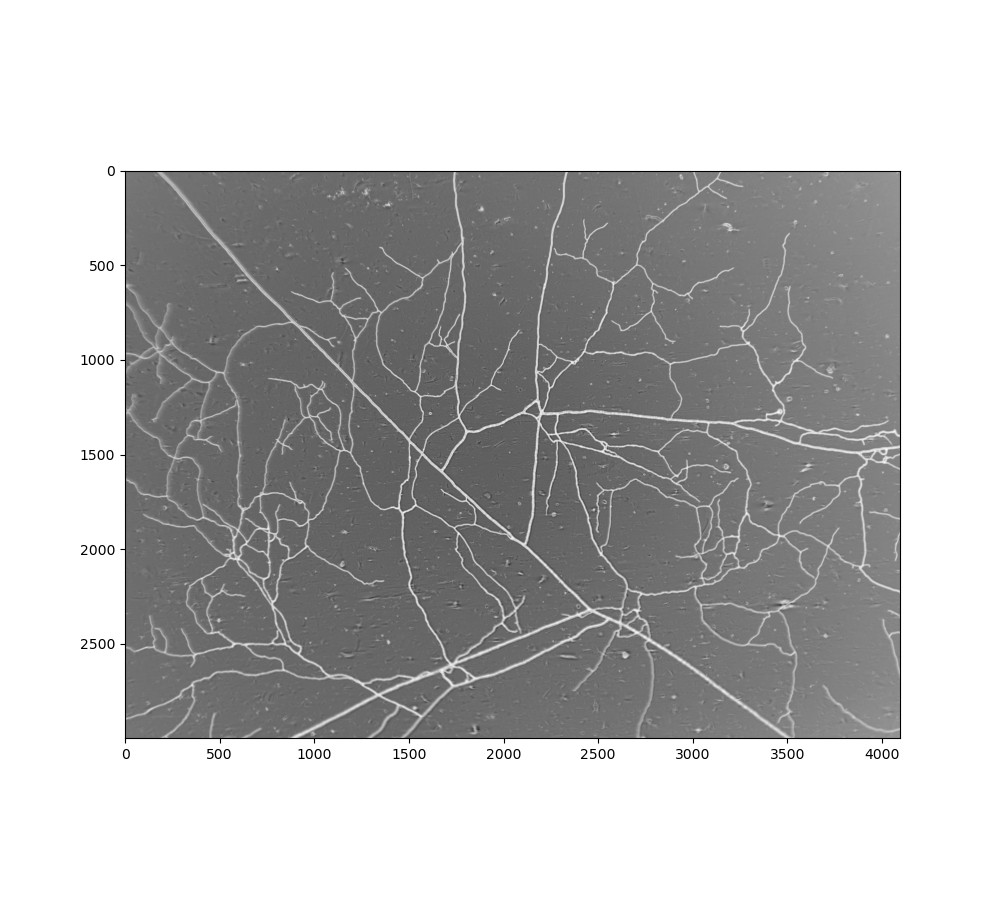

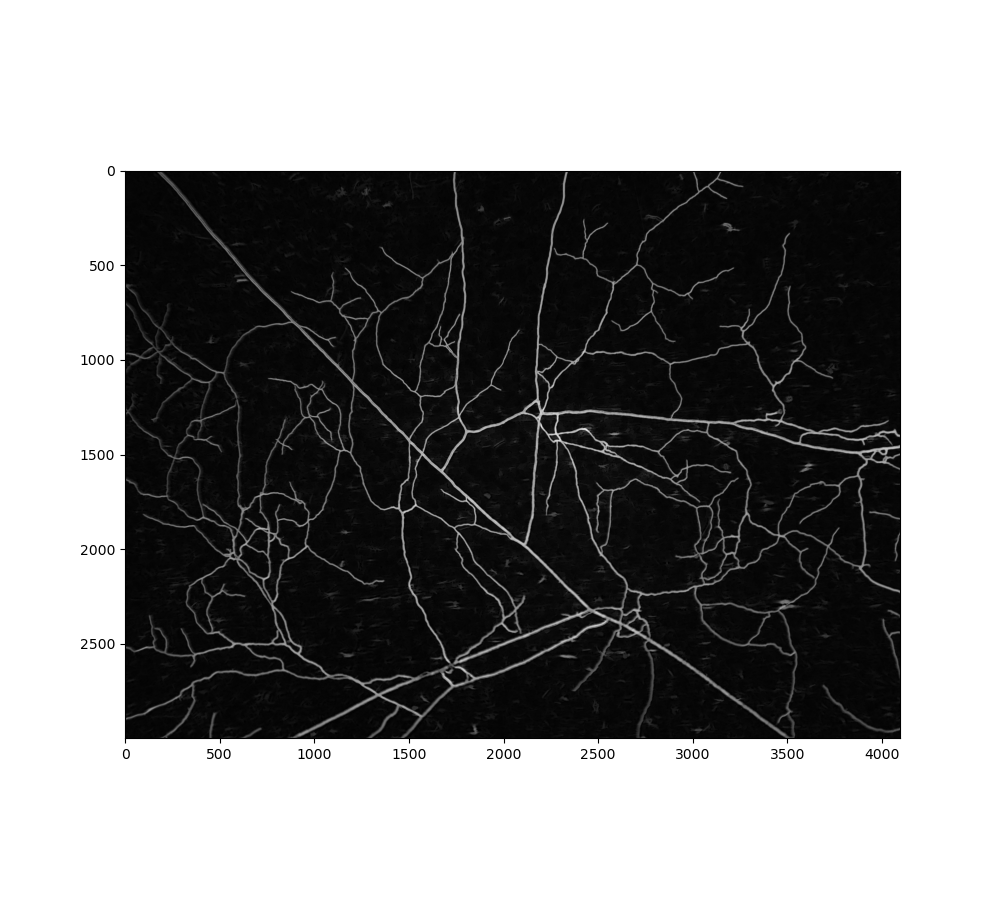

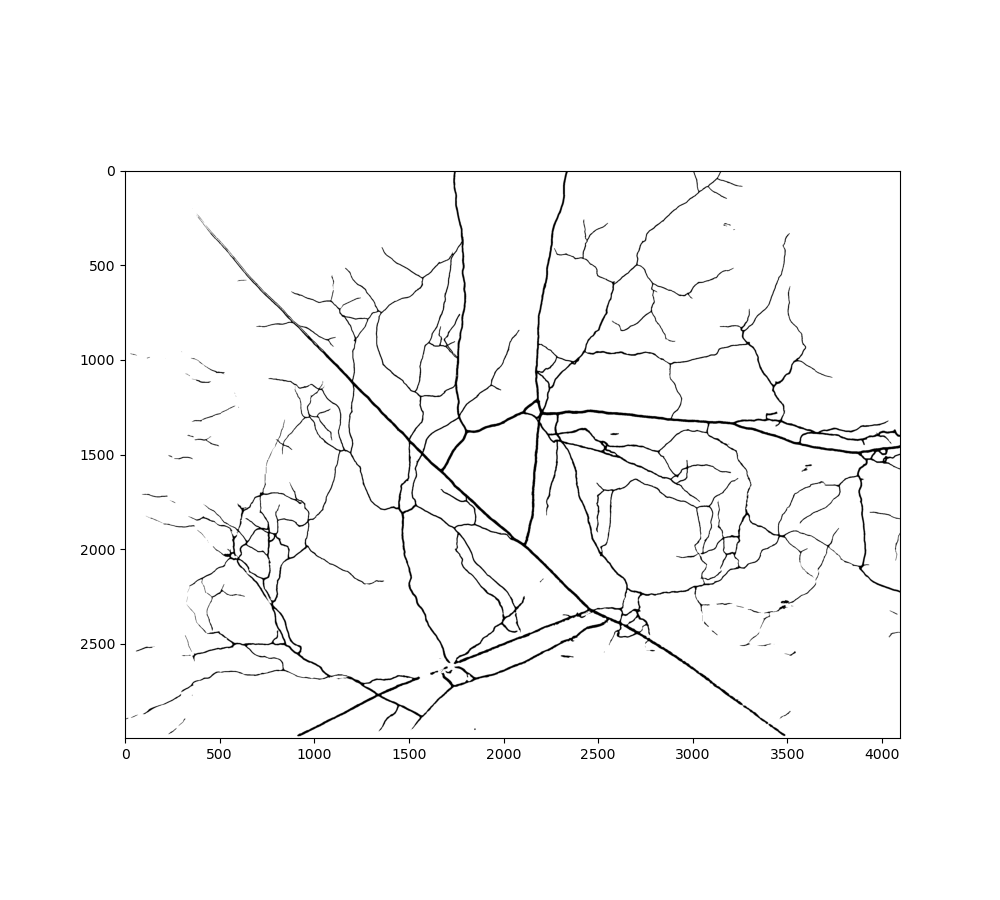

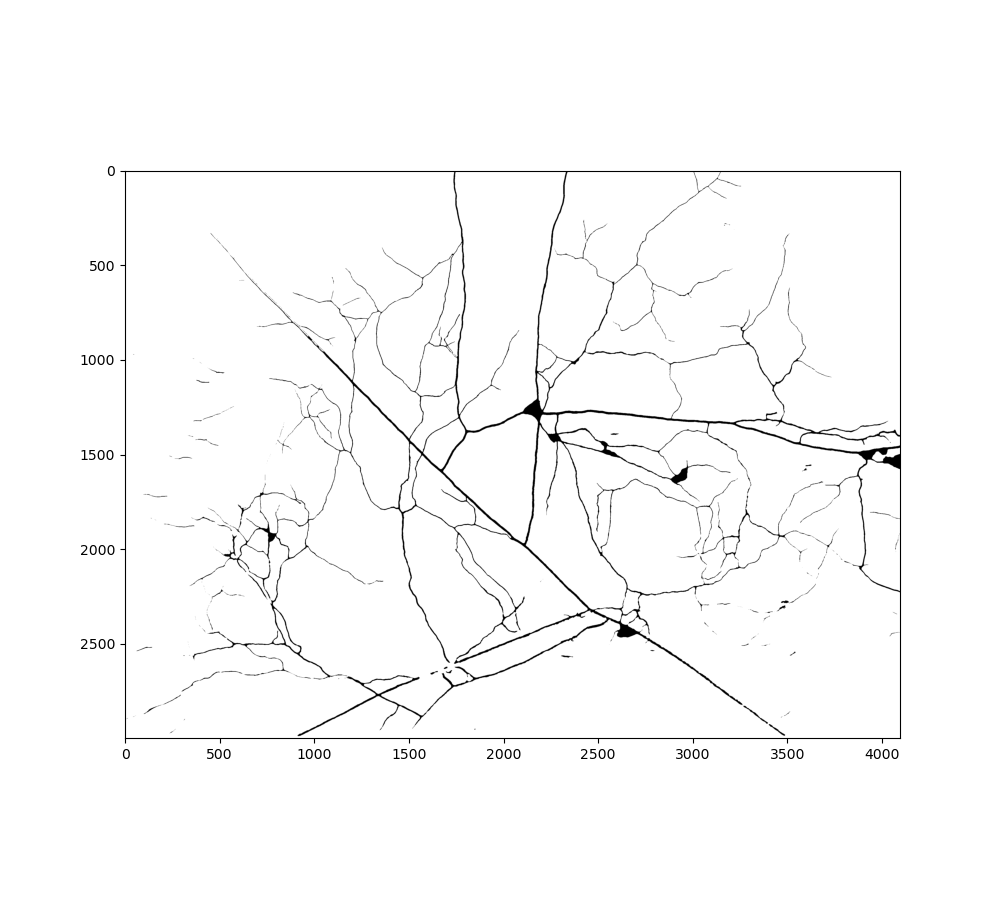

In [5]:
plt.close("all")
fig = plt.figure(figsize=(10, 9))
ax = fig.add_subplot(111)
ax.imshow(-im, cmap="gray")
fig = plt.figure(figsize=(10, 9))
ax = fig.add_subplot(111)
ax.imshow(255 * bowled_hat, cmap="gray")
fig = plt.figure(figsize=(10, 9))
ax = fig.add_subplot(111)
ax.imshow(hyst, cmap="gray")
fig = plt.figure(figsize=(10, 9))
ax = fig.add_subplot(111)
ax.imshow(img2, cmap="gray")

In [29]:
fig = plt.figure(figsize=(10, 9))
ax = fig.add_subplot(111)
ax.imshow(img2, cmap="Greens")
ax.imshow(-im, cmap="gray", alpha=0.5)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [3]:
plate_number = 721
plate = get_postion_number(plate_number)
# plate = 29
print(plate)
# directory = directory_scratch
directory = directory_project
listdir = os.listdir(directory)
list_dir_interest = [
    name
    for name in listdir
    if name.split("_")[-1] == f'Plate{0 if plate<10 else ""}{plate}'
]
dates_datetime = get_dates_datetime(directory, plate)
len(list_dir_interest)
begin = 131
end = begin + 80
print("begin =", dates_datetime[begin], "\n  end =", dates_datetime[end])

38
begin = 2021-08-18 13:24:00 
  end = 2021-08-25 07:25:00


In [4]:
# chose i equal to the timestep where something wrong has been noticed
i = begin + 10

dates_datetime = get_dates_datetime(directory, plate)
dates = dates_datetime

date = dates[i]
directory_name = get_dirname(date, plate)
path_snap = directory + directory_name
path_tile = path_snap + "/Img/TileConfiguration.txt.registered"
try:
    tileconfig = pd.read_table(
        path_tile,
        sep=";",
        skiprows=4,
        header=None,
        converters={2: ast.literal_eval},
        skipinitialspace=True,
    )
except:
    print("error_name")
    path_tile = path_snap + "/Img/TileConfiguration.registered.txt"
    tileconfig = pd.read_table(
        path_tile,
        sep=";",
        skiprows=4,
        header=None,
        converters={2: ast.literal_eval},
        skipinitialspace=True,
    )
xs = [c[0] for c in tileconfig[2]]
ys = [c[1] for c in tileconfig[2]]
dim = (int(np.max(ys) - np.min(ys)) + 4096, int(np.max(xs) - np.min(xs)) + 4096)
ims = []
for name in tileconfig[0]:
    imname = "/Img/" + name.split("/")[-1]
    ims.append(imageio.imread(directory + directory_name + imname))

In [8]:
plt.close("all")

# chose a spot where to look closer at
linex = 4100
liney = 6400
low = 40
high = 80
extend = 30
dist = extend
shape = (3000, 4096)
linex *= 5
liney *= 5
no = 15
si = [30]
for index, im in enumerate(ims):
    boundaries = int(tileconfig[2][index][0] - np.min(xs)), int(
        tileconfig[2][index][1] - np.min(ys)
    )
    if (
        boundaries[1] <= linex < boundaries[1] + shape[0]
        and boundaries[0] <= liney < boundaries[0] + shape[1]
    ):
        print(index)
        im_cropped = im
        im_blurred = cv.blur(im_cropped, (200, 200))
        im_back_rem = (
            (im_cropped)
            / ((im_blurred == 0) * np.ones(im_blurred.shape) + im_blurred)
            * 120
        )
        im_back_rem[im_back_rem >= 130] = 130
        im = np.double(-im)
        im = (im - np.min(im[:])) / (np.max(im[:]) - np.min(im[:]))
        bowled_hat = bowler_hat(im, no, si)
        frangised = frangi(im_back_rem, sigmas=range(1, 20, 4)) * 255
        fig = plt.figure(figsize=(10, 9))
        ax = fig.add_subplot(111)
        ax.imshow(im, cmap="gray")
        fig = plt.figure(figsize=(10, 9))
        ax = fig.add_subplot(111)
        ax.imshow(bowled_hat, cmap="gray")
        fig = plt.figure(figsize=(10, 9))
        ax = fig.add_subplot(111)
        ax.imshow(frangised, cmap="gray")
        fig = plt.figure(figsize=(10, 9))
        ax = fig.add_subplot(111)
        ax.imshow(0.2 < bowled_hat, cmap="gray")

92


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

107


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [7]:
a = 2
b = 1
low = 40
high = 120
transformed = (a * bowled_hat * 255 + b * frangised) / (a + b)
lowt = (transformed > low).astype(int)
hight = (transformed > high).astype(int)
hyst = filters.apply_hysteresis_threshold(transformed, low, high)
fig = plt.figure(figsize=(10, 9))
ax = fig.add_subplot(111)
ax.imshow(hyst, cmap="gray")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [ ]:
kernel = np.ones((3, 3), np.uint8)
dilation = cv2.dilate(hyst.astype(np.uint8) * 255, kernel, iterations=1)
for i in range(3):
    dilation = cv2.erode(dilation.astype(np.uint8) * 255, kernel, iterations=1)
    dilation = cv2.dilate(dilation.astype(np.uint8) * 255, kernel, iterations=1)
dilated = dilation > 0
nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(
    dilated.astype(np.uint8), connectivity=8
)
# connectedComponentswithStats yields every seperated component with information on each of them, such as size
# the following part is just taking out the background which is also considered a component, but most of the time we don't want that.
sizes = stats[1:, -1]
nb_components = nb_components - 1

# minimum size of particles we want to keep (number of pixels)
# here, it's a fixed value, but you can set it as you want, eg the mean of the sizes or whatever
min_size = 4000

# your answer image
img2 = np.zeros((dilated.shape))
# for every component in the image, you keep it only if it's above min_size
for i in range(0, nb_components):
    if sizes[i] >= min_size:
        img2[output == i + 1] = 1
skeletonized = cv2.ximgproc.thinning(np.array(255 * img2, dtype=np.uint8))
nx_g = generate_nx_graph(from_sparse_to_graph(scipy.sparse.dok_matrix(skeletonized)))
g, pos = nx_g